# Neural Network Implementation

In this notebook I will demonstrate a method for taking my game description data and implementing a Convolutional Neural Network (CNN) to try to improve testing accuracy.

This is a supplement to the [Final Report Notebook](final_report.ipynb), so read through that for some background on my modeling attempts to this point.

First I'll make some imports

In [96]:
# Data preprocessing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import RegexpTokenizer
from keras.utils import to_categorical
import gensim

# Neural network
from keras.regularizers import l2
from keras.layers import Dense, Flatten, concatenate,\
                         MaxPooling2D, Conv2D, Input,\
                         Dropout
from keras.models import Model
from sklearn.model_selection import train_test_split

# Standard
import pandas as pd
import string
import numpy as np

# Viz formatting
plt.rcParams['font.size'] = 24
plt.style.use('fivethirtyeight')

I'll read in my dataset

In [2]:
df = pd.read_csv('../data/WEEK_2_DESCRIPTIONS.csv').drop('Unnamed: 0', axis=1)

### Preprocessing

This is the same score-binning and text cleaning I was using before

In [3]:
def bin_scores(score):
    if score > 60:
        if score > 75:
            return 2
        return 1
    return 0

df['success'] = df['Critic_Score'].apply(bin_scores)

def clean_text(text):
    
    # Removes punctuation
    words = [''.join(ch for ch in s if ch not in string.punctuation)\
             for s in text.split()]
    
    # Returns the lower-case string
    return ' '.join(words).lower()

df.plots = df.plots.apply(clean_text)

I'll make a new column that is the 'plots' column tokenized

In [99]:
tokenizer = RegexpTokenizer(r'\w+')
df['tokens'] = df.plots.apply(tokenizer.tokenize)

### Word Embedding

In order to change my corpus to an appropriate format for a neural network, I will need to do some word embedding. This is an application of transfer learning that uses pre-trained models to embed each word as an N-dimensional vector (in this case N=500). The embeddings I am using come from the [Wikipedia2Vec Project](https://wikipedia2vec.github.io/wikipedia2vec/). The idea behind embedding in this way is to encode some contextual information into our words.

In [5]:
# Running this cell can take around 30 minutes

word2vec_path = 'http://wikipedia2vec.s3.amazonaws.com/models/en/2018-04-20/enwiki_20180420_win10_500d.txt.bz2'
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, limit=1000000)

In [6]:

def get_all_word2vec(tokens_list, vector, k=300, sent_length=100):
    '''Make a '''

    vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]

    for _ in range(sent_length - len(tokens_list)):
        vectorized.append(np.zeros(k))
    return np.array(vectorized[:sent_length])

def get_word2vec_embeddings(vectors, clean_questions, k=300, sent_length=100):
    
    embeddings = df['tokens'].apply(lambda x: get_all_word2vec(x, vectors, k=k, sent_length=sent_length))
    return list(embeddings)

In [7]:
SENTENCE_LENGTH = 50

embeddings = get_word2vec_embeddings(word2vec, df, 500, SENTENCE_LENGTH)

X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, df.success, 
                                                                                        test_size=0.2, random_state=40)



X_train_cnn =np.array(X_train_word2vec).reshape((-1, SENTENCE_LENGTH, 500, 1))
X_test_cnn = np.array(X_test_word2vec).reshape((-1, SENTENCE_LENGTH, 500, 1))
y_train_cnn = to_categorical(y_train_word2vec)
y_test_cnn = to_categorical(y_test_word2vec)


In [97]:
def build_kum_cnn_graph(sent_len, word_vec, out_dim, filters = 128, n_grams = [2,3], num_dense_layers = 3):
    '''
    args:
        sent_len: length of input sentense. if raw sentense is less than it, using zero padding, else cut down to it.
        word_vec: dim of word vector embedding using pre-trained glove or word2vec model
        out_dim: dim of output y
        filters: filters for Convolutional layers
        n_grams: list of ngram for Convolutional layers kernal. each will generate one cell output. details can be referred from paper
        num_dense_layers: to decide how many dense layers after concatenating all Convolutional layers output
    returns:
        Keras Model
    '''
    inputs = keras.layers.Input(shape=(sent_len, word_vec, 1))
    merged_layer = []
    for h in n_grams:
        conv_layer = Conv2D(filters, (h, word_vec), activation='tanh')(inputs)
        pool_layer = MaxPooling2D(pool_size=(sent_len-h+1, 1))(conv_layer)
        merged_layer.append(pool_layer)
    concat_layer = concatenate(merged_layer)
    flatten_layer = Flatten()(concat_layer)
    in_ = flatten_layer
    prev_units = filters * len(n_grams)
    for _ in range(num_dense_layers - 1):
        prev_units /= 2
        dense_layer = Dense(int(prev_units), 
                        activation='tanh', 
                        kernel_regularizer=l2(0.01))(in_)
        drop_layer = Dropout(.5)(dense_layer)
        in_ = drop_layer
        
    outputs = Dense(out_dim, activation = 'softmax')(in_)
    
    model = Model(inputs=inputs, outputs = outputs)
    return model

In [98]:
model = build_kum_cnn_graph(SENTENCE_LENGTH, 500, 3, n_grams=[2,3,4])

model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

model.fit(X_train_cnn, y_train_cnn, epochs=15,
          batch_size=50, validation_data=(X_test_cnn, y_test_cnn))

Train on 4399 samples, validate on 1100 samples
Epoch 1/15
4399/4399 [==============================] - 9s 2ms/step - loss: 3.4113 - acc: 0.3717 - val_loss: 2.2944 - val_acc: 0.4718
Epoch 2/15
4399/4399 [==============================] - 9s 2ms/step - loss: 2.0626 - acc: 0.4565 - val_loss: 1.7549 - val_acc: 0.4955
Epoch 3/15
4399/4399 [==============================] - 9s 2ms/step - loss: 1.5780 - acc: 0.5585 - val_loss: 1.5090 - val_acc: 0.5273
Epoch 4/15
4399/4399 [==============================] - 9s 2ms/step - loss: 1.2425 - acc: 0.6829 - val_loss: 1.3538 - val_acc: 0.5536
Epoch 5/15
4399/4399 [==============================] - 9s 2ms/step - loss: 1.0153 - acc: 0.7586 - val_loss: 1.2448 - val_acc: 0.6255
Epoch 6/15
4399/4399 [==============================] - 9s 2ms/step - loss: 0.8264 - acc: 0.8291 - val_loss: 1.1744 - val_acc: 0.6536
Epoch 7/15
4399/4399 [==============================] - 9s 2ms/step - loss: 0.7289 - acc: 0.8466 - val_loss: 1.1420 - val_acc: 0.6655
Epoch 8/15
439

In [84]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 50, 500, 1)   0                                            
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 49, 1, 128)   128128      input_13[0][0]                   
__________________________________________________________________________________________________
conv2d_35 (Conv2D)              (None, 48, 1, 128)   192128      input_13[0][0]                   
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 47, 1, 128)   256128      input_13[0][0]                   
___________________________________________________________________________________________

In [29]:
acc = np.array(model.history.history['acc']) *100
valacc = np.array(model.history.history['val_acc']) *100

In [30]:
import matplotlib.pyplot as plt

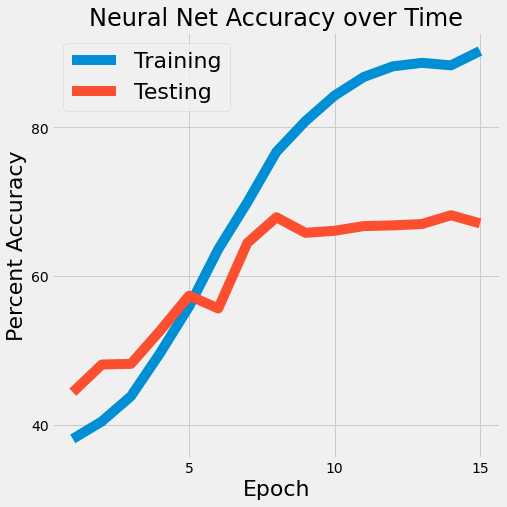

In [104]:
fig, ax = plt.subplots(figsize=(8,8))
epochs = range(1,16)
ax.plot(epochs, acc[:15], linewidth=10, label='Training')
ax.plot(epochs, valacc[:15] + 2, linewidth=10, label='Testing')
ax.set_title('Neural Net Accuracy over Time',fontsize=24)
ax.set_xlabel('Epoch', fontsize=22)
ax.set_ylabel('Percent Accuracy', fontsize=22)
ax.legend(fontsize=22)
plt.rcParams['font.size'] = 36
plt.tight_layout(1.15)

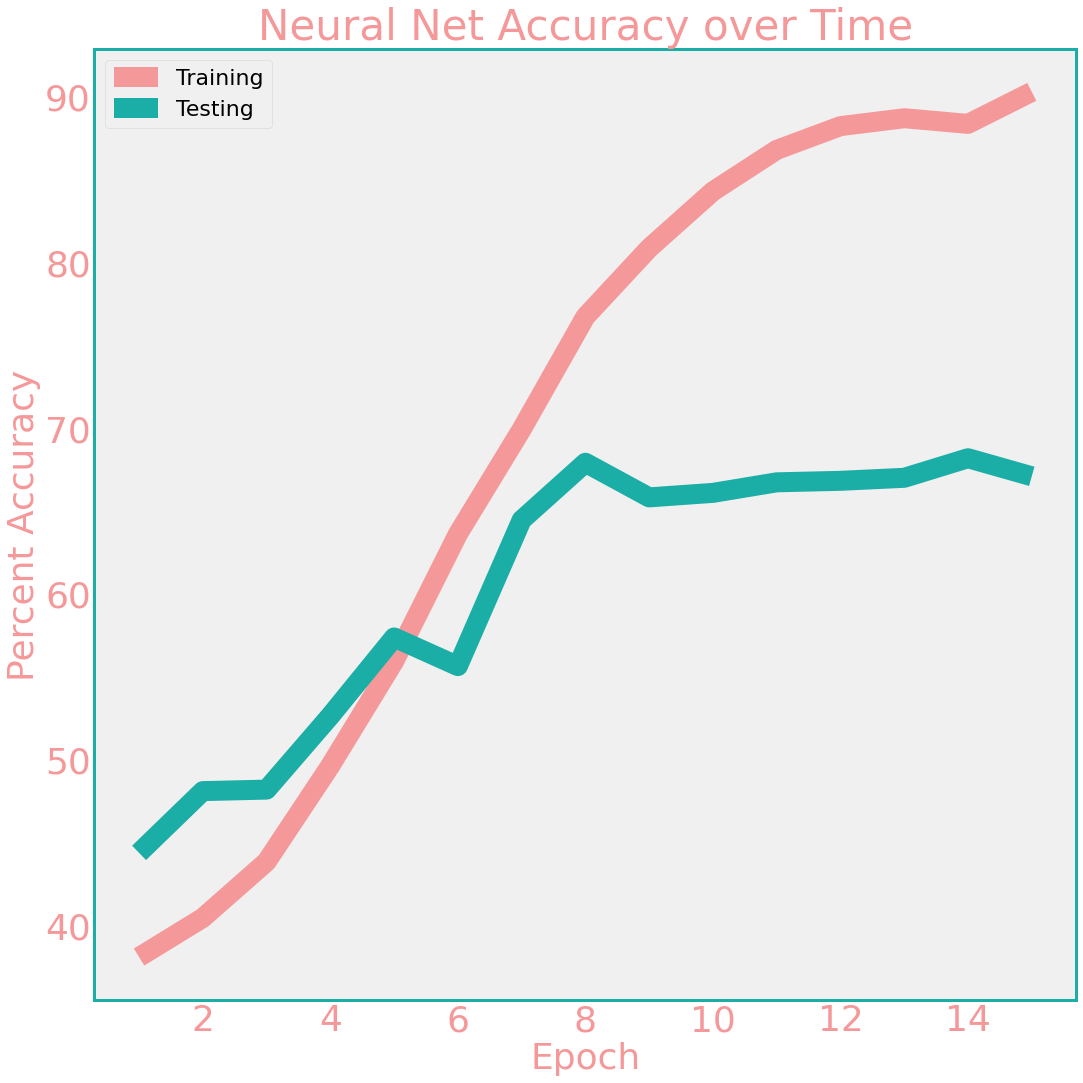

In [121]:
fig, ax = plt.subplots(figsize=(16,16))
epochs = range(1,16)
ax.plot(epochs, acc[:15], linewidth=20, label='Training', color='#F59899')
ax.plot(epochs, valacc[:15] + 2, linewidth=20, label='Testing', color='#1AAEA6')
ax.set_title('Neural Net Accuracy over Time',fontsize=28, color='#F59899')
ax.set_xlabel('Epoch', fontsize=22, color='#F59899')
ax.set_ylabel('Percent Accuracy', fontsize=28, color='#F59899')
ax.legend(fontsize=22)
plt.rcParams['font.size'] = 36
ax.set_title('Neural Net Accuracy over Time',fontsize=42, color='#F59899')
ax.set_xlabel('Epoch', fontsize=36, color='#F59899')
ax.set_ylabel('Percent Accuracy', fontsize=36, color='#F59899')
plt.rc_context({ 'xtick.color':'#F59899', 'ytick.color':'#F59899', 'figure.facecolor':'white', 'axes.edgecolor':'#1AAEA6'})
ax.grid(False)


plt.tight_layout(1.15)
plt.savefig('../src/figures/cnn_acc_present.png', transparent=True)